<a href="https://colab.research.google.com/drive/1IxiJ0fjBvuVslq86bR-WogzvKGoVYlJz">Abre este Jupyter en Google Colab</a>

# Caso Práctico: _Support Vector Machine (SVM)_

## Conjunto de datos: Titanic

### Descripción
El hundimiento del Titanic es uno de los naufragios más tristemente célebres de la historia.

El 15 de abril de 1912, durante su viaje inaugural, el considerado "insumergible" RMS Titanic se hundió tras chocar con un iceberg. Desgraciadamente, no había suficientes botes salvavidas para todos los ocupantes, lo que provocó la muerte de 1.502 de los 2.224 pasajeros y tripulantes.

Aunque hubo un elemento de suerte en la supervivencia, parece que algunos grupos de personas tenían más probabilidades de sobrevivir que otros.

En este reto, te pedimos que construyas un modelo predictivo que responda a la pregunta: "¿qué tipo de personas tenían más probabilidades de sobrevivir?" utilizando los datos de los pasajeros (es decir, nombre, edad, sexo, clase socioeconómica, etc.).


## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline

In [2]:
import warnings
# Ignoramos algunos warnings que se producen por invocar el pipeline sin el nombre de las características
warnings.filterwarnings('ignore', category=UserWarning, message='.*X does not have valid feature names.*')
warnings.filterwarnings('ignore', category=RuntimeWarning, message='.*invalid value encountered in subtract.*')

## Funciones auxiliares

In [3]:
# Construcción de una función que realice el particionado completo
def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
    train_set, test_set = train_test_split(df, test_size=0.4, random_state=rstate, shuffle=shuffle, stratify=stratify)
    return train_set, test_set

In [4]:
# Representación gráfica del límite de decisión
def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

## 1. Lectura del conjunto de datos

In [5]:
df = pd.read_csv("train.csv")

## 2. Visualización preliminar de la información

In [6]:
df.head(None)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [8]:
# Comprobación de si existen valores nulos
is_null = df.isna().any()
if is_null.any():
    print("Hay valores nulos en el dataframe:")
    print(df.dropna().head())
else:
    print("No hay valores nulos en el dataframe")

Hay valores nulos en el dataframe:
    PassengerId  Survived  Pclass  \
1             2         1       1   
3             4         1       1   
6             7         0       1   
10           11         1       3   
11           12         1       1   

                                                 Name     Sex   Age  SibSp  \
1   Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
3        Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
6                             McCarthy, Mr. Timothy J    male  54.0      0   
10                    Sandstrom, Miss. Marguerite Rut  female   4.0      1   
11                           Bonnell, Miss. Elizabeth  female  58.0      0   

    Parch    Ticket     Fare Cabin Embarked  
1       0  PC 17599  71.2833   C85        C  
3       0    113803  53.1000  C123        S  
6       0     17463  51.8625   E46        S  
10      1   PP 9549  16.7000    G6        S  
11      0    113783  26.5500  C103        S

In [9]:
# Comprobación de la existencia de valores infinitos
is_inf_or_nan = pd.isna(df)

if is_inf_or_nan.any().any():
    print("Hay valores infinitos o NaN en el dataframe:")
    print(df.columns[is_inf_or_nan.any()])
else:
    print("No hay valores infinitos o NaN en el dataframe")

Hay valores infinitos o NaN en el dataframe:
Index(['Age', 'Cabin', 'Embarked'], dtype='object')


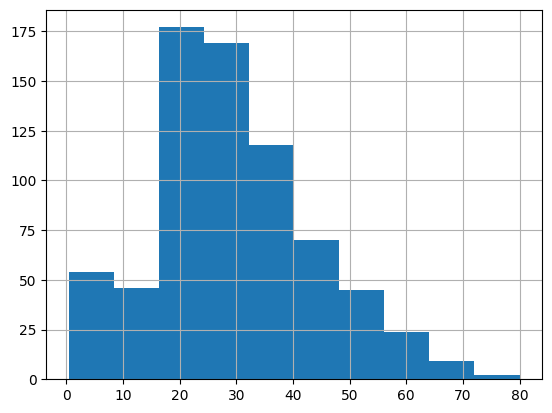

In [10]:
df['Age'].hist()
plt.show()

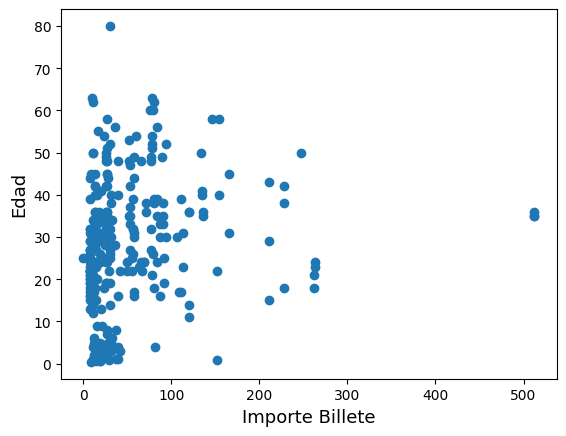

In [12]:
plt.scatter(df[df['Survived'] == 1]['Fare'], df[df['Survived'] == 1]['Age'])
plt.xlabel("Importe Billete", fontsize=13)
plt.ylabel("Edad", fontsize=13)
plt.show()

## 3. División del conjunto de datos

In [21]:
# División del conjunto de datos
train_set, test_set = train_val_test_split(df, rstate=42)

In [22]:
# Carga del archivo CSV
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Selección de las características relevantes para el modelo
X_train = train_df.drop(['Survived'], axis=1)
y_train = train_df['Survived']

# No es necesario dividir los datos en conjunto de entrenamiento y prueba, ya que tenemos un conjunto de validación separado.


## 4. Preparación del conjunto de datos

In [30]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Carga del conjunto de datos
train_df = pd.read_csv('train.csv')

# Separa las variables numéricas y categóricas
numerical_cols = ['Age', 'Fare']
categorical_cols = ['Pclass', 'Sex', 'Embarked']

# Aplica one-hot encoding a las variables categóricas
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')
X_train_categ = pd.DataFrame(one_hot_encoder.fit_transform(train_df[categorical_cols]).toarray(), columns=one_hot_encoder.get_feature_names_out(categorical_cols))

# Combina las variables numéricas y categóricas en un solo dataframe
X_train  = train_df[numerical_cols].join(X_train_categ)

# Aplica escalado de características a las variables numéricas (opcional)
scaler  = StandardScaler()
X_train[['Age', 'Fare']]  = scaler.fit_transform(X_train[['Age', 'Fare']])

# Verifica el estado del conjunto de datos preparados
print(X_train.head())

        Age      Fare  Pclass_1  Pclass_2  Pclass_3  Sex_female  Sex_male  \
0 -0.530377 -0.502445       0.0       0.0       1.0         0.0       1.0   
1  0.571831  0.786845       1.0       0.0       0.0         1.0       0.0   
2 -0.254825 -0.488854       0.0       0.0       1.0         1.0       0.0   
3  0.365167  0.420730       1.0       0.0       0.0         1.0       0.0   
4  0.365167 -0.486337       0.0       0.0       1.0         0.0       1.0   

   Embarked_C  Embarked_Q  Embarked_S  Embarked_nan  
0         0.0         0.0         1.0           0.0  
1         1.0         0.0         0.0           0.0  
2         0.0         0.0         1.0           0.0  
3         0.0         0.0         1.0           0.0  
4         0.0         0.0         1.0           0.0  


## 5. SMV: Kernel lineal

### 5.1 Conjunto de datos reducido

**Entrenamiento del algoritmo con un conjunto de datos reducido**

In [ ]:
# Reducimos el conjunto de datos para representarlo gráficamente
X_train_reduced = X_train_prep[["Survived", "domainlength"]].copy()
X_val_reduced = X_val_prep[["domainUrlRatio", "domainlength"]].copy()

In [ ]:
X_train_reduced

In [ ]:
from sklearn.svm import SVC

# SVM Large Margin Classification
svm_clf = SVC(kernel="linear", C=50)
svm_clf.fit(X_train_reduced, y_train)

**Representación del límite de decisión**

In [ ]:
def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(X_train_reduced.values[:, 0][y_train=="phishing"], X_train_reduced.values[:, 1][y_train=="phishing"], "g^")
plt.plot(X_train_reduced.values[:, 0][y_train=="benign"], X_train_reduced.values[:, 1][y_train=="benign"], "bs")
plot_svc_decision_boundary(svm_clf, 0, 1)
plt.title("$C = {}$".format(svm_clf.C), fontsize=16)
plt.axis([0, 1, -100, 250])
plt.xlabel("domainUrlRatio", fontsize=13)
plt.ylabel("domainlength", fontsize=13)
plt.show()

**Predicción con un conjunto de datos reducido**

In [ ]:
y_pred = svm_clf.predict(X_val_reduced)

In [ ]:
print("F1 Score:", f1_score(y_pred, y_val, pos_label='phishing'))

Como se verá más adelante, para determinados kernels es muy importante escalar el conjunto de datos. En ese caso, para el kernel lineal, no es tan relevante, aunque es posible que proporciones mejores resultados.

In [ ]:
svm_clf_sc = Pipeline([
        ("scaler", RobustScaler()),
        ("linear_svc", SVC(kernel="linear", C=50)),
    ])

svm_clf_sc.fit(X_train_reduced, y_train)

In [ ]:
y_pred = svm_clf_sc.predict(X_val_reduced)

In [ ]:
print("F1 Score:", f1_score(y_pred, y_val, pos_label='phishing'))

### 5.2 Conjunto de datos completo

In [ ]:
# Entrenamiento con todo el conjunto de datos
from sklearn.svm import SVC

svm_clf = SVC(kernel="linear", C=1)
svm_clf.fit(X_train_prep, y_train)

In [ ]:
y_pred = svm_clf.predict(X_val_prep)

In [ ]:
print("F1 Score:", f1_score(y_pred, y_val, pos_label='phishing'))

## 6. SMV: Kernel no lineal

### 6.1. Polynomial Kernel (I)

**Entrenamiento del algoritmo con un conjunto de datos reducido**

In [ ]:
# Para representar el límite de decisión tenemos que pasar la variable objetivo a numérica
y_train_num = y_train.factorize()[0]
y_val_num = y_val.factorize()[0]

In [ ]:
from sklearn.datasets import make_moons
from sklearn.svm import LinearSVC
from sklearn.preprocessing import PolynomialFeatures

polynomial_svm_clf = Pipeline([
        ("poly_features", PolynomialFeatures(degree=3)),
        ("scaler", StandardScaler()),
        ("svm_clf", LinearSVC(C=20, loss="hinge", random_state=42, max_iter=100000, dual=True))
    ])

polynomial_svm_clf.fit(X_train_reduced, y_train_num)

**Representación del límite de decisión**

In [ ]:
def plot_dataset(X, y):
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g.")
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "b.")

In [ ]:
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

fig, axes = plt.subplots(ncols=2, figsize=(15,5), sharey=True)
plt.sca(axes[0])
plot_dataset(X_train_reduced.values, y_train_num)
plot_predictions(polynomial_svm_clf, [0, 1, -100, 250])
plt.xlabel("domainUrlRatio", fontsize=11)
plt.ylabel("domainlength", fontsize=11)
plt.sca(axes[1])
plot_predictions(polynomial_svm_clf, [0, 1, -100, 250])
plt.xlabel("domainUrlRatio", fontsize=11)
plt.ylabel("domainlength", fontsize=11)
plt.show()

**Predicción con el conjunto de datos reducido**

In [ ]:
y_pred = polynomial_svm_clf.predict(X_val_reduced)

In [ ]:
print("F1 Score:", f1_score(y_pred, y_val_num))

### 6.2. Polynomial Kernel (II)

Existe una forma más sencilla de entrenar un algoritmo SVM que utilize polynomial kernel utilizando el parámetro **kernel** de la propia función implementada en sklearn

**Entrenamiento del algoritmo con un conjunto de datos reducido**

In [ ]:
svm_clf = SVC(kernel="poly", degree=3, coef0=10, C=20)
svm_clf.fit(X_train_reduced, y_train_num)

**Representación del límite de decisión**

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(15,5), sharey=True)
plt.sca(axes[0])
plot_dataset(X_train_reduced.values, y_train_num)
plot_predictions(svm_clf, [0, 1, -100, 250])
plt.xlabel("domainUrlRatio", fontsize=11)
plt.ylabel("domainlength", fontsize=11)
plt.sca(axes[1])
plot_predictions(svm_clf, [0, 1, -100, 250])
plt.xlabel("domainUrlRatio", fontsize=11)
plt.ylabel("domainlength", fontsize=11)
plt.show()

**Predicción con un conjunto de datos reducido**

In [ ]:
y_pred = svm_clf.predict(X_val_reduced)

In [ ]:
print("F1 Score:", f1_score(y_pred, y_val_num))

**Predicción con el conjunto de datos completo**

In [ ]:
svm_clf = SVC(kernel="poly", degree=3, coef0=10, C=40)
svm_clf.fit(X_train_prep, y_train_num)

In [ ]:
y_pred = svm_clf.predict(X_val_prep)

In [ ]:
print("F1 Score:", f1_score(y_pred, y_val_num))

### 6.2. Gaussian Kernel

**Entrenamiento del algoritmo con un conjunto de datos reducido**

In [ ]:
rbf_kernel_svm_clf = Pipeline([
            ("scaler", RobustScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=0.5, C=1000))
        ])

rbf_kernel_svm_clf.fit(X_train_reduced, y_train_num)

**Representación del límite de decisión**

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(15,5), sharey=True)
plt.sca(axes[0])
plot_dataset(X_train_reduced.values, y_train_num)
plot_predictions(rbf_kernel_svm_clf, [0, 1, -100, 250])
plt.xlabel("domainUrlRatio", fontsize=11)
plt.ylabel("domainlength", fontsize=11)
plt.sca(axes[1])
plot_predictions(rbf_kernel_svm_clf, [0, 1, -100, 250])
plt.xlabel("domainUrlRatio", fontsize=11)
plt.ylabel("domainlength", fontsize=11)
plt.show()

**Predicción con un conjunto de datos reducido**

In [ ]:
y_pred = rbf_kernel_svm_clf.predict(X_val_reduced)

In [ ]:
print("F1 Score:", f1_score(y_pred, y_val_num))

**Predicción con un conjunto de datos completo**

In [ ]:
rbf_kernel_svm_clf = Pipeline([
            ("scaler", RobustScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=0.05, C=1000))
        ])

rbf_kernel_svm_clf.fit(X_train_prep, y_train_num)

In [ ]:
y_pred = rbf_kernel_svm_clf.predict(X_val_prep)

In [ ]:
print("F1 Score:", f1_score(y_pred, y_val_num))